In [1]:
%reset -f

In [2]:
import sys
print(sys.executable)

/oak/stanford/groups/engreitz/Users/tri/envs/sc-dl/bin/python


In [3]:
import scanpy as sc
import muon as mu
import pandas as pd
import numpy as np


/oak/stanford/groups/engreitz/Users/tri/envs/sc-dl/lib/python3.11/site-packages/muon/_core/preproc.py:31: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  if Version(scanpy.__version__) < Version("1.10"):


In [4]:
import sys
sys.path.append("/oak/stanford/groups/engreitz/Users/tri/CodeBase/programDE")
from tests.synthetic_data import make_sceptre_style_synth
from src.sceptre import prepare_crt_inputs

In [5]:
data_dir = "/oak/stanford/groups/engreitz/Users/opushkar/cc_perturb/2.preprocessing_tonys_pipeline/2.normalized_data/normalized_data"
working_dir = "/oak/stanford/groups/engreitz/Users/tri/CodeBase/programDE/notebooks"

In [6]:
mdata = mu.read(f"{data_dir}/d0_normalized_gex_and_guide.h5mu")

/oak/stanford/groups/engreitz/Users/tri/envs/sc-dl/lib/python3.11/site-packages/mudata/_core/mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/oak/stanford/groups/engreitz/Users/tri/envs/sc-dl/lib/python3.11/site-packages/mudata/_core/mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [7]:
adata = mdata['GEX'].copy()

#### Import cNMF matrix

In [8]:
# 1. Define the file path
cnmf_file = "/oak/stanford/groups/engreitz/Users/ymo/IGVF_ccperturbseq/Result/012326_100k_cells_20iter_torch_halsvar_batch_e7_v100s/012326_100k_cells_20iter_torch_halsvar_batch_e7_v100s.usages.k_80.dt_2_0.consensus.txt"

# 2. Read the dataframe
usage_df = pd.read_csv(cnmf_file, sep='\t', index_col=0)

# 3. Align with adata
# This ensures every cell in adata gets its corresponding row from the file.
# Cells in adata but missing from the file will be filled with 0 
usage_aligned = usage_df.reindex(adata.obs_names).fillna(0)

# 4. Save to obsm
adata.obsm["cnmf_usage"] = usage_aligned

# 5. Validation
print(f"Loaded usage matrix shape: {adata.obsm['cnmf_usage'].shape}")
print(f"Overlap check: {usage_df.index.intersection(adata.obs_names).shape[0]} cells matched.")

Loaded usage matrix shape: (38609, 80)
Overlap check: 38609 cells matched.


In [9]:
# Guide names must match columns of guide_assignment
guide_names = list(mdata["guide"].var_names)
adata.uns["guide_names"] = guide_names

In [10]:
# Program names
adata.uns["program_names"] = list(adata.obsm["cnmf_usage"].columns)

#### Import guide assignment

In [11]:
guide_file = "/oak/stanford/groups/engreitz/Users/tri/CodeBase/programDE/notebooks/d0_sceptre_transfer/d0_grna_assignments_long.csv"

# 1. Read
df_long = pd.read_csv(guide_file)

# 2. Pivot
# aggfunc='max' ensures that if a (cell, guide) pair is listed twice, we just keep 1.
guide_dense = df_long.pivot_table(
    index='cell_id', 
    columns='grna_target', 
    values='value', 
    fill_value=0,
    aggfunc='max' 
)

# 3. Align with adata
# This ensures strict ordering matching your AnnData
guide_aligned = guide_dense.reindex(adata.obs_names, fill_value=0)

# 4. Save
adata.obsm["guide_assignment"] = guide_aligned.astype(np.int8)

print(f"✅ Loaded guide assignment: {adata.obsm['guide_assignment'].shape}")

✅ Loaded guide assignment: (38609, 1919)


#### Map guide to gene using guide name/ID

In [12]:
# guide2gene: map guide_name -> gene by taking the first token of guide_name.split('_')
guide2gene = {gn: gn.split("_", 1)[0] for gn in guide_names}
adata.uns["guide2gene"] = guide2gene

In [13]:
adata

AnnData object with n_obs × n_vars = 38609 × 16392
    obs: 'guides_per_cell', 'guide_umi_counts', 'pct_counts_ribo', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'pool', 'sample_id', 'round1', 'well', 'biological_sample', 'plate', 'bci', 'stype', 'day', 'cell_pool', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'log1p_total_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'S_score', 'G2M_score', 'phase', 'outlier', 'size_factors', 'leiden_res_0.1', 'leiden_res_0.2', 'leiden_res_0.3', 'leiden_res_0.4', 'leiden_res_0.5', 'leiden_res_0.6', 'leiden_res_0.7', 'leiden_res_0.8', 'leiden_res_0.9', 'leiden_res_1.0'
    var: 'gene_id', 'symbol', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'n_counts', 'highly_deviant', 'highly_deviant

#### Define covariates

In [14]:
# Covariates

#(~ log(response_n_nonzero) + log(response_n_umis) +
#         log(grna_n_nonzero) + log(grna_n_umis) + response_p_mito + batch)

covariates_df = pd.DataFrame({
    "batch": adata.obs['sample_id'],
    "grna_n_nonzero": np.log1p(adata.obs['guides_per_cell']),
    "grna_n_umis": np.log1p(adata.obs['guide_umi_counts']),
    "response_n_nonzero": np.log1p(adata.obs['n_genes_by_counts']),
    "response_n_umis": np.log1p(adata.obs['total_counts']),
    "response_p_mito": adata.obs['pct_counts_mt'],
})

In [15]:
adata.obsm["covar"] = covariates_df

In [16]:
adata.obsm["covar"]

,batch,grna_n_nonzero,grna_n_umis,response_n_nonzero,response_n_umis,response_p_mito
barcode,,,,,,
CCTAATCCAACAACCATCTATTAC_2,300genes:eTN5_GEX_sub2,1.791759,5.278115,7.625595,8.286583,14.708926
GGTGCGAACCTCCTGAATCCGCGA_2,300genes:eTN5_GEX_sub2,1.791759,5.176150,7.711101,8.245234,10.594932
AACTCACCATCATTCCCTGTCCCG_1,300genes:eTN5_GEX_sub1,1.609438,5.214936,7.412764,8.143888,9.923644
TTCACGCACACTTCGAATTCATGG_2,300genes:eTN5_GEX_sub2,0.000000,1.386294,6.535241,6.692704,1.738051
GTCTGTCAGAGCTGAACCGTTCTA_3,300genes:eTN5_GEX_sub3,1.386294,3.850148,7.872455,8.587198,12.086022
...,...,...,...,...,...,...
CGAACTTAGAGTTAGCATTCATGG_3,300genes:eTN5_GEX_sub3,2.564949,5.455321,7.455877,8.303146,10.494226
CCGTGAGAGAATCTGAATCGCATA_3,300genes:eTN5_GEX_sub3,1.098612,4.060443,7.095064,7.578938,13.985841
TGAAGAGACCTCTATCTCTATTAC_3,300genes:eTN5_GEX_sub3,2.079442,5.843544,7.649693,8.291139,9.166440


#### Flooring and Renormalizing cNMF matrix

In [17]:
U = adata.obsm["cnmf_usage"]
print("min:", U.min(), "quantile:", np.quantile(U, 1e-4))
print("row sums == 0:", np.sum(U.sum(axis=1) == 0))

min: 1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
     ... 
76    0.0
77    0.0
78    0.0
79    0.0
80    0.0
Length: 80, dtype: float64 quantile: 0.0
row sums == 0: 0


In [18]:
U0 = adata.obsm["cnmf_usage"]
pos = U0[U0 > 0]
eps = max(1e-8, np.quantile(pos, 0.01) * 0.1)  # e.g. 10% of 1% quantile
Uf = np.where(U0 > 0, U0, eps)
Uf = Uf / Uf.sum(axis=1, keepdims=True)
adata.obsm["cnmf_usage"] = Uf

#### Prepare input for programDE pipeline 

In [19]:

inputs = prepare_crt_inputs(
    adata=adata,
    usage_key="cnmf_usage",
    covar_key="covar",
    guide_assignment_key="guide_assignment",
    guide2gene_key="guide2gene"
)

In [20]:
from src.sceptre import (
    build_ntc_group_inputs,
    compute_ntc_group_null_pvals_parallel,
    crt_pvals_for_ntc_groups_ensemble,
    crt_pvals_for_ntc_groups_ensemble_skew,
    make_ntc_groups_ensemble,
    run_all_genes_union_crt,
)
from src.visualization import qq_plot_ntc_pvals

In [21]:
import os
cpus_per_task = int(os.environ.get("SLURM_CPUS_PER_TASK", 1))

In [22]:
cpus_per_task

4

### CRT without stratification

In [23]:

out = run_all_genes_union_crt(
    inputs=inputs,
    B=1023,
    n_jobs=cpus_per_task,
    calibrate_skew_normal=True,
    return_raw_pvals=True,
    return_skew_normal=True,
)


In [24]:
ntc_labels = ["SAFE","non-targeting"]
# Identify NTC guides and build guide-frequency bins / real-gene signatures
ntc_guides, guide_freq, guide_to_bin, real_sigs = build_ntc_group_inputs(
    inputs=inputs,
    ntc_label=ntc_labels,
    group_size=6,
    n_bins=10,
)

In [25]:

# Create multiple random partitions (ensembles) of NTC guides into 6-guide groups
ntc_groups_ens = make_ntc_groups_ensemble(
    ntc_guides=ntc_guides,
    ntc_freq=guide_freq,
    real_gene_bin_sigs=real_sigs,
    guide_to_bin=guide_to_bin,
    n_ensemble=10,
    seed0=7,
    group_size=6,
    max_groups=None,
)
# Compute raw CRT p-values for each NTC group in each ensemble
ntc_group_pvals_ens = crt_pvals_for_ntc_groups_ensemble(
    inputs=inputs,
    ntc_groups_ens=ntc_groups_ens,
    B=1023,
    seed0=23,
)
# Compute skew-calibrated CRT p-values for each NTC group in each ensemble
ntc_group_pvals_skew_ens = crt_pvals_for_ntc_groups_ensemble_skew(
    inputs=inputs,
    ntc_groups_ens=ntc_groups_ens,
    B=1023,
    seed0=23,
) 

In [ ]:
# Build CRT-null p-values matched to NTC group units (recommended)
null_pvals = compute_ntc_group_null_pvals_parallel(
    inputs=inputs,
    ntc_groups_ens=ntc_groups_ens,
    B=1023,
    n_jobs=cpus_per_task,
    backend="threading",
)

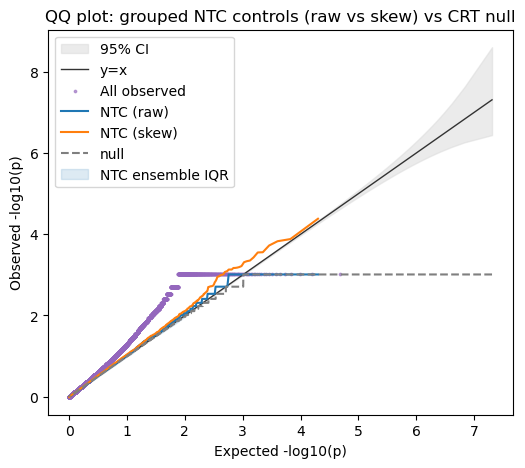

In [28]:
ax = qq_plot_ntc_pvals(
    pvals_raw_df=out["pvals_raw_df"],
    guide2gene=adata.uns["guide2gene"],
    ntc_genes=ntc_labels,
    pvals_skew_df=out["pvals_df"],
    null_pvals=null_pvals,
    ntc_group_pvals_ens=ntc_group_pvals_ens,
    ntc_group_pvals_skew_ens=ntc_group_pvals_skew_ens,
    show_ntc_ensemble_band=True,
    show_all_pvals=True,
    title="QQ plot: grouped NTC controls (raw vs skew) vs CRT null",
)

import matplotlib.pyplot as plt
plt.show()